# Gumbel-Softmax - New feature
This notebook showcases a new feature introduced in version 0.6, Gumbel-Softmax activations!

**Structure of the notebook:**

1. A quick recap on categorical feature synthesis
2. Softmax and the Gumbel-Softmax activation
3. Synthesized categorical features comparison
    * Raw sample format comparison
    * Synthesized samples comparison (categoricals)

## A quick recap on categorical feature synthesis
Before synthesizing we typically preprocess our features. In the case of categorical features, one-hot encodings are frequently used in order to transform discrete features into sparse blocks of 1's and 0's. Converting symbolic inputs like categorical features to sparse arrays allows neural network (NN) models to handle the data similarly to very different feature formats like numerical continuous features.

An example:
* Before one-hot encoding:

<style>
th {
  padding-top: 5px;
  padding-right: 10px;
  padding-bottom: 5px;
  padding-left: 10px;
}
</style>

| ID | Gender | AgeRange |
| :------------: | :-------:  | :-------:  |
| 1 | Male | 20-29 |
| 2 | Female | 10-19 |

* After one-hot encoding:

| ID | Gender_Male | Gender_Female | AgeRange_10-19 | AgeRange_20-29 |
| :------------: | :-------:  | :-------:  | :-------:  | :-------:  |
| 1 | 1 | 0 | 0 | 1 |
| 2 | 0 | 1 | 1 | 0 |

GANs attempt to synthesize these sparse distributions as they appear on real data. However, despite the input categorical features having a sparse format, NN classifiers learn __[logits](https://en.wikipedia.org/wiki/Logit)__, non-normalized probability distributions, for each class represented in the one-hot encoded input. Without activation layers that can handle this output, you might get synthetic records looking something like this:

| ID | Gender_Male | Gender_Female | AgeRange_10-19 | AgeRange_20-29 |
| :------------: | :-------:  | :-------:  | :-------:  | :-------:  |
| 1 | 0.867 | 0.622 | -0.155 | 0.855 |
| 2 | 0.032 | 1.045 | 0.901 | -0.122 |

This looks messy; leaves you with the job of inferring a sensible output (p.e. use the class with highest activation) and also is a potential flag for a GAN discriminator to identify fake samples.

Let's see what Gumbel-Softmax is and what it can do about to fix the issue!

## Softmax and the Gumbel-Softmax activation
Softmax is a differentiable family of functions that map an array of logits to probabilities, i.e. values are bounded in the range $[0, 1]$ and sum to 1.
These are often used for turning logits into probability distributions from which we can sample. However these samples can't help us in gradient descent model learning because they are obtained from a random process (no relation with the model's parameters).

The Gumbel-Softmax (GS) is a special kind of Softmax function that got introduced in 2016 (fun fact: coincidentally it was proposed in the same time by two independent teams) __[\[1](https://arxiv.org/abs/1611.00712)__, __[2\]](https://arxiv.org/abs/1611.01144)__. It works like a continuous approximation of Softmax. Instead of using logits directly __[Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution)__ noise is added before the softmax operation so that our model is outputting a combination from a deterministic component, parameterized by the mean and the variance of the categorical distribution, and a stochastic component, the Gumbel noise, which is just helping us sample without adding bias to the process.

A temperature parameter, usually called tau or lambda and defined in $]0, inf[$ is used to tune this distribution between the true categorical distribution and a uniform distribution respectively. This parameter is usually kept close to 0.

## Synthesized categorical features comparison
Now we are moving to a comparison of results before/after GS activation was added.

We will do this by first looking at raw samples format (using samples as they leave the generator, before inverting any pre-processing) and synthetic samples categorical distributions with histograms.
For this comparisons we will leverage the WGAN with Gradient Penalty implementation of the library on the adult dataset. The available snippets should reproduce the results but the takeaways are fully delivered on the cached results of this notebook.
Since the new feature is already implemented in our WGAN with Gradient Penalty implementation, we will inherit it and make a very simple override so that we use a generator without the GS activation.

### Raw sample format comparison
This comparison is similar to the examples in the introduction section. We are looking for one-hot encoded features as the samples leave the generator.

In [1]:
from pmlb import fetch_data

from ydata_synthetic.synthesizers.regular import WGAN_GP
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

data = fetch_data('adult')
num_cols = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_cols = ['workclass','education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
            'native-country', 'target']


# WGAN_GP training
# Defining the training parameters of WGAN_GP

noise_dim = 32
dim = 128
batch_size = 500

log_step = 100
epochs = 150
learning_rate = [5e-4, 3e-3]
beta_1 = 0.5
beta_2 = 0.9

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

n_discriminator = 3
sample_size = 15000

In [2]:
# Mimicking the WGAN_GP implementation without GS
class NoGS_WGAN_GP(WGAN_GP):
    """The simple override of the define_gan below blocks the generator from plugging in the GS activation layer.
    This makes it equivalent to the previous implementation.
    The source code will help you understanding how it works"""
    def define_gan(self, activation_info = None):
        super().define_gan(activation_info=None)

In [3]:
from tensorflow.random import uniform
from tensorflow.dtypes import float32

# Random noise for sampling both generators
noise = uniform([sample_size, noise_dim], dtype=float32)

print('WGAN_GP without GS version train')
no_gs_wgan = NoGS_WGAN_GP(gan_args, n_discriminator)
no_gs_wgan.train(data, train_args, num_cols, cat_cols)

print('WGAN_GP with GS version train')
gs_wgan = WGAN_GP(gan_args, n_discriminator)
gs_wgan.train(data, train_args, num_cols, cat_cols)


WGAN_GP without GS version train


  1%|          | 1/150 [00:04<12:16,  4.95s/it]

Epoch: 0 | disc_loss: 7.001818656921387 | gen_loss: 0.032102733850479126


  1%|▏         | 2/150 [00:07<09:18,  3.78s/it]

Epoch: 1 | disc_loss: 0.3212931752204895 | gen_loss: -0.013624361716210842


  2%|▏         | 3/150 [00:10<08:14,  3.36s/it]

Epoch: 2 | disc_loss: 0.015131283551454544 | gen_loss: -0.0336611308157444


  3%|▎         | 4/150 [00:13<07:41,  3.16s/it]

Epoch: 3 | disc_loss: 0.17736250162124634 | gen_loss: -0.016914166510105133


  3%|▎         | 5/150 [00:16<07:24,  3.06s/it]

Epoch: 4 | disc_loss: 0.036320269107818604 | gen_loss: -0.028907060623168945


  4%|▍         | 6/150 [00:19<07:14,  3.02s/it]

Epoch: 5 | disc_loss: -0.011208156123757362 | gen_loss: 0.0446091964840889


  5%|▍         | 7/150 [00:22<07:08,  2.99s/it]

Epoch: 6 | disc_loss: 1.0370527505874634 | gen_loss: -0.0530804768204689


  5%|▌         | 8/150 [00:25<07:03,  2.98s/it]

Epoch: 7 | disc_loss: 0.009213360957801342 | gen_loss: -0.003131201257929206


  6%|▌         | 9/150 [00:28<07:00,  2.98s/it]

Epoch: 8 | disc_loss: 0.03150836378335953 | gen_loss: -0.015168673358857632


  7%|▋         | 10/150 [00:31<07:04,  3.03s/it]

Epoch: 9 | disc_loss: 7.351823329925537 | gen_loss: -0.011977061629295349


  7%|▋         | 11/150 [00:35<07:52,  3.40s/it]

Epoch: 10 | disc_loss: 0.5849359035491943 | gen_loss: -0.018550420179963112


  8%|▊         | 12/150 [00:39<08:20,  3.63s/it]

Epoch: 11 | disc_loss: -0.013546192087233067 | gen_loss: 0.03898913040757179


  9%|▊         | 13/150 [00:43<08:36,  3.77s/it]

Epoch: 12 | disc_loss: -0.013924933969974518 | gen_loss: 0.037018876522779465


  9%|▉         | 14/150 [00:47<08:26,  3.72s/it]

Epoch: 13 | disc_loss: 2.296832323074341 | gen_loss: -0.014887027442455292


 10%|█         | 15/150 [00:50<08:03,  3.58s/it]

Epoch: 14 | disc_loss: 2.079155445098877 | gen_loss: -0.009079006500542164


 11%|█         | 16/150 [00:53<07:42,  3.45s/it]

Epoch: 15 | disc_loss: 0.1924964338541031 | gen_loss: 0.06155749037861824


 11%|█▏        | 17/150 [00:57<07:47,  3.52s/it]

Epoch: 16 | disc_loss: -0.008474241942167282 | gen_loss: 0.03532183915376663


 12%|█▏        | 18/150 [01:01<07:42,  3.50s/it]

Epoch: 17 | disc_loss: 0.013944141566753387 | gen_loss: 0.04447009786963463


 13%|█▎        | 19/150 [01:04<07:24,  3.39s/it]

Epoch: 18 | disc_loss: 0.1380799412727356 | gen_loss: 0.03745337575674057


 13%|█▎        | 20/150 [01:07<07:13,  3.33s/it]

Epoch: 19 | disc_loss: 2.533400058746338 | gen_loss: 0.05873305723071098


 14%|█▍        | 21/150 [01:10<07:07,  3.32s/it]

Epoch: 20 | disc_loss: 0.25172677636146545 | gen_loss: 0.014264167286455631


 15%|█▍        | 22/150 [01:13<06:54,  3.24s/it]

Epoch: 21 | disc_loss: 0.06304953992366791 | gen_loss: 0.018463416025042534


 15%|█▌        | 23/150 [01:16<06:47,  3.21s/it]

Epoch: 22 | disc_loss: 0.1664346605539322 | gen_loss: -0.029739074409008026


 16%|█▌        | 24/150 [01:19<06:39,  3.17s/it]

Epoch: 23 | disc_loss: -0.019534125924110413 | gen_loss: 0.056791845709085464


 17%|█▋        | 25/150 [01:22<06:29,  3.11s/it]

Epoch: 24 | disc_loss: -0.0007808096706867218 | gen_loss: 0.05845968797802925


 17%|█▋        | 26/150 [01:26<06:31,  3.15s/it]

Epoch: 25 | disc_loss: 0.009695726446807384 | gen_loss: 0.08331981301307678


 18%|█▊        | 27/150 [01:29<06:28,  3.16s/it]

Epoch: 26 | disc_loss: 0.3780527412891388 | gen_loss: 0.025466283783316612


 19%|█▊        | 28/150 [01:32<06:23,  3.14s/it]

Epoch: 27 | disc_loss: -0.0009233057498931885 | gen_loss: 0.02710898406803608


 19%|█▉        | 29/150 [01:35<06:18,  3.13s/it]

Epoch: 28 | disc_loss: 0.1925804615020752 | gen_loss: 0.056067630648612976


 20%|██        | 30/150 [01:38<06:14,  3.12s/it]

Epoch: 29 | disc_loss: 0.7571886777877808 | gen_loss: 0.03926617652177811


 21%|██        | 31/150 [01:41<06:09,  3.10s/it]

Epoch: 30 | disc_loss: 0.0034906482324004173 | gen_loss: -0.01305912435054779


 21%|██▏       | 32/150 [01:45<06:16,  3.19s/it]

Epoch: 31 | disc_loss: 0.02266201376914978 | gen_loss: 0.027070168405771255


 22%|██▏       | 33/150 [01:48<06:08,  3.15s/it]

Epoch: 32 | disc_loss: 0.005724923685193062 | gen_loss: -0.07904914021492004


 23%|██▎       | 34/150 [01:51<06:10,  3.19s/it]

Epoch: 33 | disc_loss: -0.01133497804403305 | gen_loss: -0.039054110646247864


 23%|██▎       | 35/150 [01:54<06:09,  3.21s/it]

Epoch: 34 | disc_loss: 0.18126556277275085 | gen_loss: -0.03173045068979263


 24%|██▍       | 36/150 [01:57<06:06,  3.22s/it]

Epoch: 35 | disc_loss: 0.04409971833229065 | gen_loss: -0.026473743841052055


 25%|██▍       | 37/150 [02:01<05:59,  3.18s/it]

Epoch: 36 | disc_loss: 0.0352432057261467 | gen_loss: -0.008756168186664581


 25%|██▌       | 38/150 [02:04<05:56,  3.18s/it]

Epoch: 37 | disc_loss: 0.05249788612127304 | gen_loss: -0.02504720166325569


 26%|██▌       | 39/150 [02:07<05:52,  3.18s/it]

Epoch: 38 | disc_loss: -0.004160843789577484 | gen_loss: -0.023515645414590836


 27%|██▋       | 40/150 [02:10<05:49,  3.18s/it]

Epoch: 39 | disc_loss: 0.2722225487232208 | gen_loss: -0.04678482189774513


 27%|██▋       | 41/150 [02:13<05:50,  3.22s/it]

Epoch: 40 | disc_loss: -0.002196941524744034 | gen_loss: -0.031029174104332924


 28%|██▊       | 42/150 [02:17<05:44,  3.19s/it]

Epoch: 41 | disc_loss: 0.017749983817338943 | gen_loss: -0.06138572841882706


 29%|██▊       | 43/150 [02:20<05:40,  3.18s/it]

Epoch: 42 | disc_loss: 0.03972388431429863 | gen_loss: -0.04366380721330643


 29%|██▉       | 44/150 [02:23<05:41,  3.22s/it]

Epoch: 43 | disc_loss: 0.009945999830961227 | gen_loss: -0.029304351657629013


 30%|███       | 45/150 [02:26<05:38,  3.22s/it]

Epoch: 44 | disc_loss: 0.0123140849173069 | gen_loss: -0.025341881439089775


 31%|███       | 46/150 [02:30<05:36,  3.24s/it]

Epoch: 45 | disc_loss: 0.033270563930273056 | gen_loss: -0.057440850883722305


 31%|███▏      | 47/150 [02:33<05:29,  3.20s/it]

Epoch: 46 | disc_loss: 0.005183428525924683 | gen_loss: -0.05005092918872833


 32%|███▏      | 48/150 [02:36<05:24,  3.19s/it]

Epoch: 47 | disc_loss: -0.016354206949472427 | gen_loss: -0.052042651921510696


 33%|███▎      | 49/150 [02:39<05:24,  3.21s/it]

Epoch: 48 | disc_loss: -0.008736610412597656 | gen_loss: -0.06374430656433105


 33%|███▎      | 50/150 [02:42<05:19,  3.20s/it]

Epoch: 49 | disc_loss: 0.028165973722934723 | gen_loss: -0.05867326259613037


 34%|███▍      | 51/150 [02:45<05:12,  3.16s/it]

Epoch: 50 | disc_loss: 0.05059522017836571 | gen_loss: -0.042985640466213226


 35%|███▍      | 52/150 [02:48<05:08,  3.15s/it]

Epoch: 51 | disc_loss: -0.011311056092381477 | gen_loss: -0.03234931454062462


 35%|███▌      | 53/150 [02:52<05:05,  3.15s/it]

Epoch: 52 | disc_loss: 0.02519911900162697 | gen_loss: -0.06087822839617729


 36%|███▌      | 54/150 [02:55<05:02,  3.15s/it]

Epoch: 53 | disc_loss: -0.015549003146588802 | gen_loss: -0.05727221071720123


 37%|███▋      | 55/150 [02:58<04:59,  3.15s/it]

Epoch: 54 | disc_loss: 0.04653487727046013 | gen_loss: -0.06581026315689087


 37%|███▋      | 56/150 [03:01<04:56,  3.15s/it]

Epoch: 55 | disc_loss: -0.015356030315160751 | gen_loss: -0.049324970692396164


 38%|███▊      | 57/150 [03:04<04:56,  3.18s/it]

Epoch: 56 | disc_loss: 0.04886408895254135 | gen_loss: -0.07573284953832626


 39%|███▊      | 58/150 [03:08<04:53,  3.19s/it]

Epoch: 57 | disc_loss: -0.016304977238178253 | gen_loss: -0.06776045262813568


 39%|███▉      | 59/150 [03:11<04:55,  3.25s/it]

Epoch: 58 | disc_loss: 0.052330270409584045 | gen_loss: -0.1773097664117813


 40%|████      | 60/150 [03:14<04:50,  3.23s/it]

Epoch: 59 | disc_loss: -0.010557781904935837 | gen_loss: -0.08099358528852463


 41%|████      | 61/150 [03:17<04:45,  3.20s/it]

Epoch: 60 | disc_loss: -0.011919313110411167 | gen_loss: -0.06489657610654831


 41%|████▏     | 62/150 [03:20<04:36,  3.14s/it]

Epoch: 61 | disc_loss: -0.006818230263888836 | gen_loss: -0.06074857711791992


 42%|████▏     | 63/150 [03:23<04:29,  3.10s/it]

Epoch: 62 | disc_loss: -0.017775915563106537 | gen_loss: -0.050270926207304


 43%|████▎     | 64/150 [03:26<04:23,  3.07s/it]

Epoch: 63 | disc_loss: -0.018374497070908546 | gen_loss: -0.05593691021203995


 43%|████▎     | 65/150 [03:29<04:19,  3.05s/it]

Epoch: 64 | disc_loss: 0.002448391169309616 | gen_loss: -0.05812082439661026


 44%|████▍     | 66/150 [03:32<04:20,  3.10s/it]

Epoch: 65 | disc_loss: -0.008553532883524895 | gen_loss: -0.04846079647541046


 45%|████▍     | 67/150 [03:36<04:19,  3.12s/it]

Epoch: 66 | disc_loss: -0.017901042476296425 | gen_loss: -0.06434981524944305


 45%|████▌     | 68/150 [03:39<04:19,  3.17s/it]

Epoch: 67 | disc_loss: -0.015237990766763687 | gen_loss: -0.061880726367235184


 46%|████▌     | 69/150 [03:42<04:13,  3.13s/it]

Epoch: 68 | disc_loss: -0.016777178272604942 | gen_loss: -0.07721734046936035


 47%|████▋     | 70/150 [03:45<04:07,  3.09s/it]

Epoch: 69 | disc_loss: 0.02830154448747635 | gen_loss: -0.07977316528558731


 47%|████▋     | 71/150 [03:48<04:02,  3.06s/it]

Epoch: 70 | disc_loss: -0.01831112988293171 | gen_loss: -0.06813133507966995


 48%|████▊     | 72/150 [03:51<03:57,  3.05s/it]

Epoch: 71 | disc_loss: 0.12461423873901367 | gen_loss: -0.09788011014461517


 49%|████▊     | 73/150 [03:54<03:54,  3.04s/it]

Epoch: 72 | disc_loss: -0.019517777487635612 | gen_loss: -0.07622293382883072


 49%|████▉     | 74/150 [03:57<03:58,  3.13s/it]

Epoch: 73 | disc_loss: -0.014753812924027443 | gen_loss: -0.09615010023117065


 50%|█████     | 75/150 [04:01<03:57,  3.16s/it]

Epoch: 74 | disc_loss: -0.015279949642717838 | gen_loss: -0.08278822153806686


 51%|█████     | 76/150 [04:04<03:52,  3.14s/it]

Epoch: 75 | disc_loss: -0.0073950449004769325 | gen_loss: -0.06505242735147476


 51%|█████▏    | 77/150 [04:07<03:51,  3.17s/it]

Epoch: 76 | disc_loss: -0.0073962886817753315 | gen_loss: -0.06926890462636948


 52%|█████▏    | 78/150 [04:10<03:54,  3.26s/it]

Epoch: 77 | disc_loss: -0.017221879214048386 | gen_loss: -0.0752170979976654


 53%|█████▎    | 79/150 [04:14<03:50,  3.25s/it]

Epoch: 78 | disc_loss: -0.007039135321974754 | gen_loss: -0.06713178753852844


 53%|█████▎    | 80/150 [04:17<03:46,  3.23s/it]

Epoch: 79 | disc_loss: -0.010615878738462925 | gen_loss: -0.06182413175702095


 54%|█████▍    | 81/150 [04:20<03:42,  3.22s/it]

Epoch: 80 | disc_loss: -0.013474461622536182 | gen_loss: -0.07489178329706192


 55%|█████▍    | 82/150 [04:23<03:41,  3.26s/it]

Epoch: 81 | disc_loss: -0.017540674656629562 | gen_loss: -0.0717400386929512


 55%|█████▌    | 83/150 [04:27<03:38,  3.25s/it]

Epoch: 82 | disc_loss: -0.0142907639965415 | gen_loss: -0.06902061402797699


 56%|█████▌    | 84/150 [04:30<03:34,  3.25s/it]

Epoch: 83 | disc_loss: -0.010849446058273315 | gen_loss: -0.0628233402967453


 57%|█████▋    | 85/150 [04:33<03:30,  3.24s/it]

Epoch: 84 | disc_loss: -0.01926765777170658 | gen_loss: -0.07623761892318726


 57%|█████▋    | 86/150 [04:36<03:26,  3.23s/it]

Epoch: 85 | disc_loss: 0.02000182867050171 | gen_loss: -0.06576837599277496


 58%|█████▊    | 87/150 [04:39<03:23,  3.23s/it]

Epoch: 86 | disc_loss: -0.012086468748748302 | gen_loss: -0.06509753316640854


 59%|█████▊    | 88/150 [04:43<03:19,  3.22s/it]

Epoch: 87 | disc_loss: -0.005679847672581673 | gen_loss: -0.0731641873717308


 59%|█████▉    | 89/150 [04:46<03:16,  3.22s/it]

Epoch: 88 | disc_loss: 0.0002632811665534973 | gen_loss: -0.06918077915906906


 60%|██████    | 90/150 [04:49<03:13,  3.22s/it]

Epoch: 89 | disc_loss: 0.007955709472298622 | gen_loss: -0.07209262996912003


 61%|██████    | 91/150 [04:52<03:10,  3.22s/it]

Epoch: 90 | disc_loss: -0.016388343647122383 | gen_loss: -0.06013893708586693


 61%|██████▏   | 92/150 [04:56<03:06,  3.22s/it]

Epoch: 91 | disc_loss: 0.13734126091003418 | gen_loss: -0.06414060294628143


 62%|██████▏   | 93/150 [04:59<03:03,  3.22s/it]

Epoch: 92 | disc_loss: -0.007688162848353386 | gen_loss: -0.07736655324697495


 63%|██████▎   | 94/150 [05:02<03:00,  3.22s/it]

Epoch: 93 | disc_loss: 0.021637316793203354 | gen_loss: -0.0650772899389267


 63%|██████▎   | 95/150 [05:05<02:56,  3.22s/it]

Epoch: 94 | disc_loss: -0.013475021347403526 | gen_loss: -0.07084992527961731


 64%|██████▍   | 96/150 [05:08<02:53,  3.21s/it]

Epoch: 95 | disc_loss: -0.010956178419291973 | gen_loss: -0.05354185774922371


 65%|██████▍   | 97/150 [05:12<02:50,  3.22s/it]

Epoch: 96 | disc_loss: -0.014343254268169403 | gen_loss: -0.057488471269607544


 65%|██████▌   | 98/150 [05:15<02:47,  3.23s/it]

Epoch: 97 | disc_loss: -0.004384598694741726 | gen_loss: -0.05850352719426155


 66%|██████▌   | 99/150 [05:18<02:44,  3.23s/it]

Epoch: 98 | disc_loss: 0.12105216085910797 | gen_loss: -0.04990190640091896


 67%|██████▋   | 100/150 [05:21<02:41,  3.22s/it]

Epoch: 99 | disc_loss: -0.003399878740310669 | gen_loss: -0.06120958551764488


 67%|██████▋   | 101/150 [05:25<02:38,  3.23s/it]

Epoch: 100 | disc_loss: -0.005066646263003349 | gen_loss: -0.058454856276512146


 68%|██████▊   | 102/150 [05:28<02:35,  3.23s/it]

Epoch: 101 | disc_loss: 0.33892199397087097 | gen_loss: 0.003055702894926071


 69%|██████▊   | 103/150 [05:31<02:31,  3.23s/it]

Epoch: 102 | disc_loss: -0.009077364578843117 | gen_loss: -0.03269456326961517


 69%|██████▉   | 104/150 [05:34<02:28,  3.23s/it]

Epoch: 103 | disc_loss: 0.010782696306705475 | gen_loss: -0.026254190132021904


 70%|███████   | 105/150 [05:38<02:26,  3.25s/it]

Epoch: 104 | disc_loss: -0.001619085669517517 | gen_loss: -0.034151848405599594


 71%|███████   | 106/150 [05:41<02:20,  3.20s/it]

Epoch: 105 | disc_loss: -0.0002054409123957157 | gen_loss: 0.015532808378338814


 71%|███████▏  | 107/150 [05:44<02:16,  3.17s/it]

Epoch: 106 | disc_loss: 0.004205668345093727 | gen_loss: -0.0025466091465204954


 72%|███████▏  | 108/150 [05:47<02:11,  3.14s/it]

Epoch: 107 | disc_loss: -0.005869777407497168 | gen_loss: 0.005269757471978664


 73%|███████▎  | 109/150 [05:50<02:07,  3.12s/it]

Epoch: 108 | disc_loss: 0.04277686029672623 | gen_loss: 0.04294378682971001


 73%|███████▎  | 110/150 [05:53<02:04,  3.10s/it]

Epoch: 109 | disc_loss: 0.012050524353981018 | gen_loss: 0.0399540551006794


 74%|███████▍  | 111/150 [05:56<02:00,  3.09s/it]

Epoch: 110 | disc_loss: -0.006765264086425304 | gen_loss: 0.041482165455818176


 75%|███████▍  | 112/150 [05:59<01:57,  3.09s/it]

Epoch: 111 | disc_loss: 0.15276867151260376 | gen_loss: 0.03341428190469742


 75%|███████▌  | 113/150 [06:02<01:53,  3.08s/it]

Epoch: 112 | disc_loss: 0.0807642862200737 | gen_loss: 0.03895297273993492


 76%|███████▌  | 114/150 [06:05<01:50,  3.07s/it]

Epoch: 113 | disc_loss: 0.08284483850002289 | gen_loss: 0.05387355387210846


 77%|███████▋  | 115/150 [06:08<01:47,  3.08s/it]

Epoch: 114 | disc_loss: -0.009696205146610737 | gen_loss: 0.03718649968504906


 77%|███████▋  | 116/150 [06:11<01:44,  3.08s/it]

Epoch: 115 | disc_loss: 0.014457136392593384 | gen_loss: 0.04857080057263374


 78%|███████▊  | 117/150 [06:14<01:41,  3.07s/it]

Epoch: 116 | disc_loss: 0.08893105387687683 | gen_loss: 0.04455516114830971


 79%|███████▊  | 118/150 [06:17<01:38,  3.08s/it]

Epoch: 117 | disc_loss: 0.008424587547779083 | gen_loss: 0.060059431940317154


 79%|███████▉  | 119/150 [06:21<01:35,  3.08s/it]

Epoch: 118 | disc_loss: 0.08665387332439423 | gen_loss: 0.03401436284184456


 80%|████████  | 120/150 [06:24<01:32,  3.08s/it]

Epoch: 119 | disc_loss: -0.007277627009898424 | gen_loss: 0.04971984773874283


 81%|████████  | 121/150 [06:27<01:29,  3.08s/it]

Epoch: 120 | disc_loss: 0.01110851764678955 | gen_loss: 0.04288610816001892


 81%|████████▏ | 122/150 [06:30<01:26,  3.08s/it]

Epoch: 121 | disc_loss: 0.07024773210287094 | gen_loss: 0.0697425827383995


 82%|████████▏ | 123/150 [06:33<01:23,  3.08s/it]

Epoch: 122 | disc_loss: 0.00035605859011411667 | gen_loss: 0.06324552744626999


 83%|████████▎ | 124/150 [06:36<01:19,  3.07s/it]

Epoch: 123 | disc_loss: 0.004238024353981018 | gen_loss: 0.05736382678151131


 83%|████████▎ | 125/150 [06:39<01:16,  3.07s/it]

Epoch: 124 | disc_loss: -0.010084609501063824 | gen_loss: 0.06279066205024719


 84%|████████▍ | 126/150 [06:42<01:13,  3.07s/it]

Epoch: 125 | disc_loss: 0.08108150959014893 | gen_loss: 0.06366647034883499


 85%|████████▍ | 127/150 [06:45<01:10,  3.07s/it]

Epoch: 126 | disc_loss: -0.014770793728530407 | gen_loss: 0.06753744184970856


 85%|████████▌ | 128/150 [06:48<01:07,  3.06s/it]

Epoch: 127 | disc_loss: 0.09336445480585098 | gen_loss: 0.06096670404076576


 86%|████████▌ | 129/150 [06:51<01:04,  3.07s/it]

Epoch: 128 | disc_loss: -0.0047525679692626 | gen_loss: 0.05524912849068642


 87%|████████▋ | 130/150 [06:54<01:01,  3.07s/it]

Epoch: 129 | disc_loss: 0.17431527376174927 | gen_loss: 0.06400084495544434


 87%|████████▋ | 131/150 [06:57<00:58,  3.07s/it]

Epoch: 130 | disc_loss: 0.003887563943862915 | gen_loss: 0.09365598857402802


 88%|████████▊ | 132/150 [07:00<00:55,  3.07s/it]

Epoch: 131 | disc_loss: -0.011608771979808807 | gen_loss: 0.08226599544286728


 89%|████████▊ | 133/150 [07:04<00:52,  3.07s/it]

Epoch: 132 | disc_loss: -0.015586145222187042 | gen_loss: 0.0876111313700676


 89%|████████▉ | 134/150 [07:07<00:49,  3.07s/it]

Epoch: 133 | disc_loss: -0.011516459286212921 | gen_loss: 0.0860162004828453


 90%|█████████ | 135/150 [07:10<00:46,  3.07s/it]

Epoch: 134 | disc_loss: -0.01378418318927288 | gen_loss: 0.08332248777151108


 91%|█████████ | 136/150 [07:13<00:43,  3.08s/it]

Epoch: 135 | disc_loss: -0.013882379978895187 | gen_loss: 0.09183122962713242


 91%|█████████▏| 137/150 [07:16<00:39,  3.08s/it]

Epoch: 136 | disc_loss: 0.013866148889064789 | gen_loss: 0.08031561970710754


 92%|█████████▏| 138/150 [07:19<00:36,  3.07s/it]

Epoch: 137 | disc_loss: -0.014065265655517578 | gen_loss: 0.0733373835682869


 93%|█████████▎| 139/150 [07:22<00:33,  3.07s/it]

Epoch: 138 | disc_loss: 0.04484201595187187 | gen_loss: 0.0716577023267746


 93%|█████████▎| 140/150 [07:25<00:30,  3.07s/it]

Epoch: 139 | disc_loss: 0.036887794733047485 | gen_loss: 0.10395056009292603


 94%|█████████▍| 141/150 [07:28<00:27,  3.08s/it]

Epoch: 140 | disc_loss: -0.0041906945407390594 | gen_loss: 0.11155208945274353


 95%|█████████▍| 142/150 [07:31<00:24,  3.08s/it]

Epoch: 141 | disc_loss: -0.008004777133464813 | gen_loss: 0.10225031524896622


 95%|█████████▌| 143/150 [07:34<00:21,  3.08s/it]

Epoch: 142 | disc_loss: 0.011463329195976257 | gen_loss: 0.07908372581005096


 96%|█████████▌| 144/150 [07:37<00:18,  3.08s/it]

Epoch: 143 | disc_loss: 0.06516698002815247 | gen_loss: 0.1031465157866478


 97%|█████████▋| 145/150 [07:40<00:15,  3.07s/it]

Epoch: 144 | disc_loss: -0.010072369128465652 | gen_loss: 0.12422952800989151


 97%|█████████▋| 146/150 [07:43<00:12,  3.07s/it]

Epoch: 145 | disc_loss: 0.01932559534907341 | gen_loss: 0.14021754264831543


 98%|█████████▊| 147/150 [07:47<00:09,  3.07s/it]

Epoch: 146 | disc_loss: 0.044998519122600555 | gen_loss: 0.1535288244485855


 99%|█████████▊| 148/150 [07:50<00:06,  3.08s/it]

Epoch: 147 | disc_loss: 0.08587358146905899 | gen_loss: 0.1344669610261917


 99%|█████████▉| 149/150 [07:53<00:03,  3.09s/it]

Epoch: 148 | disc_loss: 0.014674432575702667 | gen_loss: 0.148382306098938


100%|██████████| 150/150 [07:56<00:00,  3.18s/it]

Epoch: 149 | disc_loss: -0.0032263565808534622 | gen_loss: 0.15346874296665192
WGAN_GP with GS version train



  1%|          | 1/150 [00:05<13:13,  5.33s/it]

Epoch: 0 | disc_loss: 11.446085929870605 | gen_loss: 0.003966222982853651


  1%|▏         | 2/150 [00:08<09:59,  4.05s/it]

Epoch: 1 | disc_loss: 4.179527759552002 | gen_loss: 0.010803833603858948


  2%|▏         | 3/150 [00:11<08:58,  3.66s/it]

Epoch: 2 | disc_loss: 1.6697807312011719 | gen_loss: -0.0048987530171871185


  3%|▎         | 4/150 [00:14<08:27,  3.48s/it]

Epoch: 3 | disc_loss: 0.004219014197587967 | gen_loss: -0.0033067408949136734


  3%|▎         | 5/150 [00:18<08:09,  3.38s/it]

Epoch: 4 | disc_loss: 0.05609669163823128 | gen_loss: -0.019053127616643906


  4%|▍         | 6/150 [00:21<07:57,  3.32s/it]

Epoch: 5 | disc_loss: -0.040355149656534195 | gen_loss: 0.0038477955386042595


  5%|▍         | 7/150 [00:24<07:48,  3.27s/it]

Epoch: 6 | disc_loss: 0.29054248332977295 | gen_loss: -0.015363702550530434


  5%|▌         | 8/150 [00:27<07:41,  3.25s/it]

Epoch: 7 | disc_loss: 0.2705994248390198 | gen_loss: 0.023430587723851204


  6%|▌         | 9/150 [00:30<07:36,  3.24s/it]

Epoch: 8 | disc_loss: -0.042137399315834045 | gen_loss: 0.0027134364936500788


  7%|▋         | 10/150 [00:34<07:31,  3.22s/it]

Epoch: 9 | disc_loss: -0.0017920546233654022 | gen_loss: 0.015849994495511055


  7%|▋         | 11/150 [00:37<07:28,  3.22s/it]

Epoch: 10 | disc_loss: -0.024115821346640587 | gen_loss: -0.015668196603655815


  8%|▊         | 12/150 [00:40<07:23,  3.22s/it]

Epoch: 11 | disc_loss: 0.0512985922396183 | gen_loss: -0.029527122154831886


  9%|▊         | 13/150 [00:43<07:20,  3.21s/it]

Epoch: 12 | disc_loss: -7.46510922908783e-05 | gen_loss: -0.03775127977132797


  9%|▉         | 14/150 [00:46<07:15,  3.21s/it]

Epoch: 13 | disc_loss: -0.06445436179637909 | gen_loss: -0.031914856284856796


 10%|█         | 15/150 [00:50<07:12,  3.21s/it]

Epoch: 14 | disc_loss: -0.05567008629441261 | gen_loss: 0.0146706597879529


 11%|█         | 16/150 [00:53<07:08,  3.20s/it]

Epoch: 15 | disc_loss: 0.2518910765647888 | gen_loss: -0.008886168710887432


 11%|█▏        | 17/150 [00:56<07:05,  3.20s/it]

Epoch: 16 | disc_loss: -0.07085678726434708 | gen_loss: -0.037123553454875946


 12%|█▏        | 18/150 [00:59<07:02,  3.20s/it]

Epoch: 17 | disc_loss: -0.0517711341381073 | gen_loss: -0.006790306884795427


 13%|█▎        | 19/150 [01:02<06:59,  3.20s/it]

Epoch: 18 | disc_loss: 0.062243953347206116 | gen_loss: -0.022196384146809578


 13%|█▎        | 20/150 [01:06<06:56,  3.20s/it]

Epoch: 19 | disc_loss: -0.07024221867322922 | gen_loss: -0.011755813844501972


 14%|█▍        | 21/150 [01:09<06:52,  3.20s/it]

Epoch: 20 | disc_loss: -0.07788290828466415 | gen_loss: -0.02118493989109993


 15%|█▍        | 22/150 [01:12<06:49,  3.20s/it]

Epoch: 21 | disc_loss: -0.07283934205770493 | gen_loss: -0.0304403156042099


 15%|█▌        | 23/150 [01:15<06:46,  3.20s/it]

Epoch: 22 | disc_loss: -0.031766243278980255 | gen_loss: 0.004455170128494501


 16%|█▌        | 24/150 [01:18<06:43,  3.20s/it]

Epoch: 23 | disc_loss: -0.06452461332082748 | gen_loss: -0.0286966972053051


 17%|█▋        | 25/150 [01:22<06:39,  3.20s/it]

Epoch: 24 | disc_loss: -0.0425877571105957 | gen_loss: -0.00979156605899334


 17%|█▋        | 26/150 [01:25<06:36,  3.20s/it]

Epoch: 25 | disc_loss: -0.08110924065113068 | gen_loss: -0.04110363498330116


 18%|█▊        | 27/150 [01:28<06:32,  3.19s/it]

Epoch: 26 | disc_loss: -0.08726467937231064 | gen_loss: -0.02766023389995098


 19%|█▊        | 28/150 [01:31<06:30,  3.20s/it]

Epoch: 27 | disc_loss: -0.04541195183992386 | gen_loss: -0.036326032131910324


 19%|█▉        | 29/150 [01:34<06:27,  3.20s/it]

Epoch: 28 | disc_loss: -0.0971016213297844 | gen_loss: -0.043472543358802795


 20%|██        | 30/150 [01:38<06:24,  3.20s/it]

Epoch: 29 | disc_loss: 0.05515531450510025 | gen_loss: -0.01732725277543068


 21%|██        | 31/150 [01:41<06:21,  3.20s/it]

Epoch: 30 | disc_loss: -0.04807736724615097 | gen_loss: -0.03766657039523125


 21%|██▏       | 32/150 [01:44<06:17,  3.20s/it]

Epoch: 31 | disc_loss: -0.011232726275920868 | gen_loss: -0.020746037364006042


 22%|██▏       | 33/150 [01:47<06:14,  3.20s/it]

Epoch: 32 | disc_loss: -0.0951315313577652 | gen_loss: -0.044686123728752136


 23%|██▎       | 34/150 [01:50<06:11,  3.20s/it]

Epoch: 33 | disc_loss: 0.051165878772735596 | gen_loss: -0.04394242912530899


 23%|██▎       | 35/150 [01:54<06:08,  3.20s/it]

Epoch: 34 | disc_loss: -0.10155981034040451 | gen_loss: -0.05372574180364609


 24%|██▍       | 36/150 [01:57<06:05,  3.20s/it]

Epoch: 35 | disc_loss: -0.09772704541683197 | gen_loss: -0.048117682337760925


 25%|██▍       | 37/150 [02:00<06:01,  3.20s/it]

Epoch: 36 | disc_loss: -0.10679665952920914 | gen_loss: -0.046478111296892166


 25%|██▌       | 38/150 [02:03<05:58,  3.20s/it]

Epoch: 37 | disc_loss: -0.10528996586799622 | gen_loss: -0.05342777818441391


 26%|██▌       | 39/150 [02:06<05:55,  3.20s/it]

Epoch: 38 | disc_loss: -0.1059621274471283 | gen_loss: -0.048599664121866226


 27%|██▋       | 40/150 [02:10<05:51,  3.20s/it]

Epoch: 39 | disc_loss: -0.09597451984882355 | gen_loss: -0.027259638532996178


 27%|██▋       | 41/150 [02:13<05:48,  3.20s/it]

Epoch: 40 | disc_loss: -0.10525214672088623 | gen_loss: -0.05050218105316162


 28%|██▊       | 42/150 [02:16<05:45,  3.20s/it]

Epoch: 41 | disc_loss: -0.05010426044464111 | gen_loss: 0.002868914045393467


 29%|██▊       | 43/150 [02:19<05:42,  3.20s/it]

Epoch: 42 | disc_loss: -0.09351850301027298 | gen_loss: -0.04854777827858925


 29%|██▉       | 44/150 [02:22<05:39,  3.20s/it]

Epoch: 43 | disc_loss: -0.10113736987113953 | gen_loss: -0.038617100566625595


 30%|███       | 45/150 [02:26<05:35,  3.20s/it]

Epoch: 44 | disc_loss: 0.5075476765632629 | gen_loss: -0.04110707342624664


 31%|███       | 46/150 [02:29<05:33,  3.20s/it]

Epoch: 45 | disc_loss: -0.10246286541223526 | gen_loss: -0.04136548936367035


 31%|███▏      | 47/150 [02:32<05:29,  3.20s/it]

Epoch: 46 | disc_loss: -0.07969384640455246 | gen_loss: -0.004226492252200842


 32%|███▏      | 48/150 [02:35<05:26,  3.20s/it]

Epoch: 47 | disc_loss: -0.09877049922943115 | gen_loss: -0.04622412845492363


 33%|███▎      | 49/150 [02:38<05:23,  3.20s/it]

Epoch: 48 | disc_loss: -0.10653849691152573 | gen_loss: -0.05378911644220352


 33%|███▎      | 50/150 [02:42<05:22,  3.23s/it]

Epoch: 49 | disc_loss: -0.10708262026309967 | gen_loss: -0.04965929314494133


 34%|███▍      | 51/150 [02:45<05:21,  3.25s/it]

Epoch: 50 | disc_loss: -0.10856431722640991 | gen_loss: -0.046095557510852814


 35%|███▍      | 52/150 [02:48<05:19,  3.26s/it]

Epoch: 51 | disc_loss: -0.08214317262172699 | gen_loss: -0.062688909471035


 35%|███▌      | 53/150 [02:51<05:16,  3.26s/it]

Epoch: 52 | disc_loss: 0.11303332448005676 | gen_loss: -0.04731093347072601


 36%|███▌      | 54/150 [02:55<05:08,  3.22s/it]

Epoch: 53 | disc_loss: -0.08507810533046722 | gen_loss: -0.03488434478640556


 37%|███▋      | 55/150 [02:58<05:02,  3.19s/it]

Epoch: 54 | disc_loss: -0.10731649398803711 | gen_loss: -0.05604715645313263


 37%|███▋      | 56/150 [03:01<04:57,  3.16s/it]

Epoch: 55 | disc_loss: -0.10953304171562195 | gen_loss: -0.061691466718912125


 38%|███▊      | 57/150 [03:04<04:53,  3.15s/it]

Epoch: 56 | disc_loss: -0.09930404275655746 | gen_loss: -0.05650852993130684


 39%|███▊      | 58/150 [03:07<04:48,  3.14s/it]

Epoch: 57 | disc_loss: -0.07287238538265228 | gen_loss: -0.039829857647418976


 39%|███▉      | 59/150 [03:10<04:45,  3.13s/it]

Epoch: 58 | disc_loss: -0.10985127091407776 | gen_loss: -0.06433533877134323


 40%|████      | 60/150 [03:13<04:41,  3.13s/it]

Epoch: 59 | disc_loss: -0.052018195390701294 | gen_loss: -0.03188498318195343


 41%|████      | 61/150 [03:16<04:38,  3.12s/it]

Epoch: 60 | disc_loss: 0.12007075548171997 | gen_loss: -0.06803607940673828


 41%|████▏     | 62/150 [03:20<04:34,  3.12s/it]

Epoch: 61 | disc_loss: -0.0640077218413353 | gen_loss: -0.08163987845182419


 42%|████▏     | 63/150 [03:23<04:31,  3.13s/it]

Epoch: 62 | disc_loss: -0.09823228418827057 | gen_loss: -0.02736629731953144


 43%|████▎     | 64/150 [03:26<04:28,  3.12s/it]

Epoch: 63 | disc_loss: 0.2873716354370117 | gen_loss: -0.02713414467871189


 43%|████▎     | 65/150 [03:29<04:26,  3.13s/it]

Epoch: 64 | disc_loss: -0.04686819016933441 | gen_loss: -0.057649873197078705


 44%|████▍     | 66/150 [03:32<04:22,  3.13s/it]

Epoch: 65 | disc_loss: -0.10582563281059265 | gen_loss: -0.05707107111811638


 45%|████▍     | 67/150 [03:35<04:19,  3.12s/it]

Epoch: 66 | disc_loss: 0.11487507820129395 | gen_loss: 0.020851198583841324


 45%|████▌     | 68/150 [03:38<04:15,  3.12s/it]

Epoch: 67 | disc_loss: -0.10539441555738449 | gen_loss: -0.05515944957733154


 46%|████▌     | 69/150 [03:41<04:12,  3.12s/it]

Epoch: 68 | disc_loss: -0.10527444630861282 | gen_loss: -0.044874489307403564


 47%|████▋     | 70/150 [03:45<04:10,  3.13s/it]

Epoch: 69 | disc_loss: 0.008087322115898132 | gen_loss: -0.07278181612491608


 47%|████▋     | 71/150 [03:48<04:06,  3.12s/it]

Epoch: 70 | disc_loss: -0.10636461526155472 | gen_loss: -0.018100205808877945


 48%|████▊     | 72/150 [03:51<04:03,  3.13s/it]

Epoch: 71 | disc_loss: -0.10586286336183548 | gen_loss: -0.04705166444182396


 49%|████▊     | 73/150 [03:54<04:00,  3.12s/it]

Epoch: 72 | disc_loss: -0.11150985956192017 | gen_loss: -0.06435342878103256


 49%|████▉     | 74/150 [03:57<03:57,  3.12s/it]

Epoch: 73 | disc_loss: 0.3593538999557495 | gen_loss: -0.05815852805972099


 50%|█████     | 75/150 [04:00<03:53,  3.12s/it]

Epoch: 74 | disc_loss: 0.06819361448287964 | gen_loss: -0.053187161684036255


 51%|█████     | 76/150 [04:03<03:51,  3.12s/it]

Epoch: 75 | disc_loss: -0.11016599833965302 | gen_loss: -0.059764694422483444


 51%|█████▏    | 77/150 [04:06<03:47,  3.12s/it]

Epoch: 76 | disc_loss: -0.06037115305662155 | gen_loss: -0.05541800335049629


 52%|█████▏    | 78/150 [04:10<03:44,  3.12s/it]

Epoch: 77 | disc_loss: 0.17576050758361816 | gen_loss: -0.029291052371263504


 53%|█████▎    | 79/150 [04:13<03:41,  3.12s/it]

Epoch: 78 | disc_loss: -0.11104422062635422 | gen_loss: -0.022562740370631218


 53%|█████▎    | 80/150 [04:16<03:38,  3.12s/it]

Epoch: 79 | disc_loss: 0.031063862144947052 | gen_loss: -0.028531622141599655


 54%|█████▍    | 81/150 [04:19<03:35,  3.12s/it]

Epoch: 80 | disc_loss: 1.0967435836791992 | gen_loss: -0.06450948864221573


 55%|█████▍    | 82/150 [04:22<03:31,  3.12s/it]

Epoch: 81 | disc_loss: -0.10261093080043793 | gen_loss: -0.018483741208910942


 55%|█████▌    | 83/150 [04:25<03:28,  3.12s/it]

Epoch: 82 | disc_loss: -0.0641135722398758 | gen_loss: -0.04898928850889206


 56%|█████▌    | 84/150 [04:28<03:25,  3.12s/it]

Epoch: 83 | disc_loss: -0.10919515043497086 | gen_loss: -0.062258876860141754


 57%|█████▋    | 85/150 [04:31<03:22,  3.12s/it]

Epoch: 84 | disc_loss: 0.3690391182899475 | gen_loss: -0.05816004052758217


 57%|█████▋    | 86/150 [04:34<03:19,  3.12s/it]

Epoch: 85 | disc_loss: -0.04659575596451759 | gen_loss: -0.058401647955179214


 58%|█████▊    | 87/150 [04:38<03:16,  3.12s/it]

Epoch: 86 | disc_loss: -0.03804042935371399 | gen_loss: -0.03279057517647743


 59%|█████▊    | 88/150 [04:41<03:13,  3.12s/it]

Epoch: 87 | disc_loss: -0.10065975785255432 | gen_loss: -0.05982276424765587


 59%|█████▉    | 89/150 [04:44<03:10,  3.12s/it]

Epoch: 88 | disc_loss: -0.06890710443258286 | gen_loss: -0.05100606009364128


 60%|██████    | 90/150 [04:47<03:07,  3.12s/it]

Epoch: 89 | disc_loss: -0.11460062861442566 | gen_loss: -0.055702485144138336


 61%|██████    | 91/150 [04:50<03:04,  3.12s/it]

Epoch: 90 | disc_loss: -0.048105113208293915 | gen_loss: -0.06103382632136345


 61%|██████▏   | 92/150 [04:53<03:01,  3.13s/it]

Epoch: 91 | disc_loss: -0.10836546123027802 | gen_loss: -0.051976948976516724


 62%|██████▏   | 93/150 [04:56<03:00,  3.16s/it]

Epoch: 92 | disc_loss: 0.3196590840816498 | gen_loss: -0.0034195436164736748


 63%|██████▎   | 94/150 [05:00<02:58,  3.19s/it]

Epoch: 93 | disc_loss: 0.03609934449195862 | gen_loss: -0.07457469403743744


 63%|██████▎   | 95/150 [05:03<02:55,  3.20s/it]

Epoch: 94 | disc_loss: -0.11469593644142151 | gen_loss: -0.06203083321452141


 64%|██████▍   | 96/150 [05:06<02:52,  3.20s/it]

Epoch: 95 | disc_loss: -0.10864437371492386 | gen_loss: -0.040277380496263504


 65%|██████▍   | 97/150 [05:09<02:49,  3.20s/it]

Epoch: 96 | disc_loss: -0.08199326694011688 | gen_loss: -0.07909529656171799


 65%|██████▌   | 98/150 [05:13<02:46,  3.21s/it]

Epoch: 97 | disc_loss: -0.11576319485902786 | gen_loss: -0.05249135568737984


 66%|██████▌   | 99/150 [05:16<02:43,  3.21s/it]

Epoch: 98 | disc_loss: 0.06226654350757599 | gen_loss: -0.014153717085719109


 67%|██████▋   | 100/150 [05:19<02:41,  3.23s/it]

Epoch: 99 | disc_loss: 0.14107339084148407 | gen_loss: -0.060350265353918076


 67%|██████▋   | 101/150 [05:23<02:41,  3.29s/it]

Epoch: 100 | disc_loss: -0.10496030002832413 | gen_loss: -0.03832044079899788


 68%|██████▊   | 102/150 [05:26<02:42,  3.38s/it]

Epoch: 101 | disc_loss: -0.08791370689868927 | gen_loss: -0.05082179978489876


 69%|██████▊   | 103/150 [05:30<02:40,  3.42s/it]

Epoch: 102 | disc_loss: -0.10923487693071365 | gen_loss: -0.040250226855278015


 69%|██████▉   | 104/150 [05:33<02:41,  3.51s/it]

Epoch: 103 | disc_loss: -0.10708070546388626 | gen_loss: -0.05788944661617279


 70%|███████   | 105/150 [05:37<02:38,  3.51s/it]

Epoch: 104 | disc_loss: -0.0800737738609314 | gen_loss: -0.038934074342250824


 71%|███████   | 106/150 [05:40<02:35,  3.53s/it]

Epoch: 105 | disc_loss: 0.7751621007919312 | gen_loss: -0.06392217427492142


 71%|███████▏  | 107/150 [05:44<02:29,  3.47s/it]

Epoch: 106 | disc_loss: -0.10358477383852005 | gen_loss: -0.04619549959897995


 72%|███████▏  | 108/150 [05:47<02:24,  3.45s/it]

Epoch: 107 | disc_loss: -0.11513666063547134 | gen_loss: -0.06507620215415955


 73%|███████▎  | 109/150 [05:51<02:23,  3.50s/it]

Epoch: 108 | disc_loss: -0.003775201737880707 | gen_loss: -0.06623384356498718


 73%|███████▎  | 110/150 [05:54<02:21,  3.54s/it]

Epoch: 109 | disc_loss: -0.10992998629808426 | gen_loss: -0.041121941059827805


 74%|███████▍  | 111/150 [05:58<02:20,  3.60s/it]

Epoch: 110 | disc_loss: -0.10543068498373032 | gen_loss: -0.04037445783615112


 75%|███████▍  | 112/150 [06:01<02:12,  3.48s/it]

Epoch: 111 | disc_loss: -0.09684807062149048 | gen_loss: -0.07450452446937561


 75%|███████▌  | 113/150 [06:05<02:05,  3.40s/it]

Epoch: 112 | disc_loss: -0.11533535271883011 | gen_loss: -0.05707768723368645


 76%|███████▌  | 114/150 [06:08<02:00,  3.34s/it]

Epoch: 113 | disc_loss: -0.09142013639211655 | gen_loss: -0.0414121113717556


 77%|███████▋  | 115/150 [06:11<01:55,  3.30s/it]

Epoch: 114 | disc_loss: -0.10817532241344452 | gen_loss: -0.0687427818775177


 77%|███████▋  | 116/150 [06:14<01:51,  3.29s/it]

Epoch: 115 | disc_loss: -0.06490222364664078 | gen_loss: -0.06736815720796585


 78%|███████▊  | 117/150 [06:17<01:47,  3.27s/it]

Epoch: 116 | disc_loss: -0.04428112506866455 | gen_loss: -0.04422847181558609


 79%|███████▊  | 118/150 [06:21<01:43,  3.24s/it]

Epoch: 117 | disc_loss: -0.1044330894947052 | gen_loss: -0.03354572877287865


 79%|███████▉  | 119/150 [06:24<01:40,  3.23s/it]

Epoch: 118 | disc_loss: -0.11780387908220291 | gen_loss: -0.0705055370926857


 80%|████████  | 120/150 [06:27<01:36,  3.23s/it]

Epoch: 119 | disc_loss: -0.10942392796278 | gen_loss: -0.03656915947794914


 81%|████████  | 121/150 [06:30<01:33,  3.21s/it]

Epoch: 120 | disc_loss: 0.21725359559059143 | gen_loss: -0.05441482365131378


 81%|████████▏ | 122/150 [06:33<01:29,  3.20s/it]

Epoch: 121 | disc_loss: -0.11041975766420364 | gen_loss: -0.007643532939255238


 82%|████████▏ | 123/150 [06:37<01:26,  3.20s/it]

Epoch: 122 | disc_loss: -0.08200277388095856 | gen_loss: -0.0586557611823082


 83%|████████▎ | 124/150 [06:40<01:23,  3.19s/it]

Epoch: 123 | disc_loss: -0.05744542181491852 | gen_loss: -0.09102284908294678


 83%|████████▎ | 125/150 [06:43<01:19,  3.20s/it]

Epoch: 124 | disc_loss: -0.0837487131357193 | gen_loss: -0.06543216109275818


 84%|████████▍ | 126/150 [06:46<01:16,  3.19s/it]

Epoch: 125 | disc_loss: -0.10588820278644562 | gen_loss: -0.07562846690416336


 85%|████████▍ | 127/150 [06:49<01:13,  3.19s/it]

Epoch: 126 | disc_loss: -0.1141955554485321 | gen_loss: -0.06978360563516617


 85%|████████▌ | 128/150 [06:53<01:10,  3.19s/it]

Epoch: 127 | disc_loss: -0.10845398157835007 | gen_loss: -0.030652837827801704


 86%|████████▌ | 129/150 [06:56<01:06,  3.19s/it]

Epoch: 128 | disc_loss: -0.10541390627622604 | gen_loss: -0.060000356286764145


 87%|████████▋ | 130/150 [06:59<01:03,  3.20s/it]

Epoch: 129 | disc_loss: -0.11388228833675385 | gen_loss: -0.052662815898656845


 87%|████████▋ | 131/150 [07:02<01:00,  3.21s/it]

Epoch: 130 | disc_loss: 0.015440821647644043 | gen_loss: -0.05176853388547897


 88%|████████▊ | 132/150 [07:05<00:57,  3.20s/it]

Epoch: 131 | disc_loss: -0.11251581460237503 | gen_loss: -0.061809804290533066


 89%|████████▊ | 133/150 [07:09<00:54,  3.20s/it]

Epoch: 132 | disc_loss: -0.10677137970924377 | gen_loss: -0.011534418910741806


 89%|████████▉ | 134/150 [07:12<00:51,  3.20s/it]

Epoch: 133 | disc_loss: 0.25219330191612244 | gen_loss: -0.058642249554395676


 90%|█████████ | 135/150 [07:15<00:47,  3.20s/it]

Epoch: 134 | disc_loss: -0.011732429265975952 | gen_loss: -0.0771310031414032


 91%|█████████ | 136/150 [07:18<00:44,  3.20s/it]

Epoch: 135 | disc_loss: -0.10211683809757233 | gen_loss: -0.019189437851309776


 91%|█████████▏| 137/150 [07:21<00:41,  3.20s/it]

Epoch: 136 | disc_loss: -0.11040106415748596 | gen_loss: -0.03462252765893936


 92%|█████████▏| 138/150 [07:25<00:38,  3.19s/it]

Epoch: 137 | disc_loss: -0.10565557330846786 | gen_loss: -0.0630454421043396


 93%|█████████▎| 139/150 [07:28<00:35,  3.19s/it]

Epoch: 138 | disc_loss: -0.05946661904454231 | gen_loss: -0.09077975153923035


 93%|█████████▎| 140/150 [07:31<00:31,  3.19s/it]

Epoch: 139 | disc_loss: -0.11518698930740356 | gen_loss: -0.07391475886106491


 94%|█████████▍| 141/150 [07:34<00:28,  3.19s/it]

Epoch: 140 | disc_loss: 0.8795115947723389 | gen_loss: -0.06375738233327866


 95%|█████████▍| 142/150 [07:37<00:25,  3.19s/it]

Epoch: 141 | disc_loss: -0.10213010013103485 | gen_loss: -0.07945995032787323


 95%|█████████▌| 143/150 [07:40<00:22,  3.19s/it]

Epoch: 142 | disc_loss: -0.11996205896139145 | gen_loss: -0.08535674959421158


 96%|█████████▌| 144/150 [07:44<00:19,  3.19s/it]

Epoch: 143 | disc_loss: -0.11954770237207413 | gen_loss: -0.10026334226131439


 97%|█████████▋| 145/150 [07:47<00:15,  3.19s/it]

Epoch: 144 | disc_loss: -0.11939753592014313 | gen_loss: -0.10003332793712616


 97%|█████████▋| 146/150 [07:50<00:12,  3.19s/it]

Epoch: 145 | disc_loss: 0.03812481462955475 | gen_loss: -0.04518786445260048


 98%|█████████▊| 147/150 [07:53<00:09,  3.21s/it]

Epoch: 146 | disc_loss: -0.11675694584846497 | gen_loss: -0.09000533819198608


 99%|█████████▊| 148/150 [07:57<00:06,  3.33s/it]

Epoch: 147 | disc_loss: -0.11900369077920914 | gen_loss: -0.06097099557518959


 99%|█████████▉| 149/150 [08:01<00:03,  3.44s/it]

Epoch: 148 | disc_loss: -0.03149644285440445 | gen_loss: -0.08727417141199112


100%|██████████| 150/150 [08:04<00:00,  3.23s/it]

Epoch: 149 | disc_loss: -0.11547007411718369 | gen_loss: -0.0692463144659996


In [4]:
# Sample both generators - We use raw samples (before inverting the data preprocessing) in order to compare the samples as they are returned by the generator
no_gs_samples = no_gs_wgan.generator(noise, training=False).numpy()
gs_samples = gs_wgan.generator(noise, training=False).numpy()

In [5]:
from pandas import DataFrame

# Get the input/output data preprocessor map to help us isolate the categorical feats output
preprocessor_map = gs_wgan.processor.col_transform_info

# Isolate the categorical features and get the feature names
n_num_feats = len(preprocessor_map.numerical.feat_names_in)
cat_out_names = preprocessor_map.categorical.feat_names_out

# Place the categorical parts of the samples in Pandas DataFrames
no_gs_cat_raw = DataFrame(no_gs_samples[:,n_num_feats:], columns=cat_out_names)
gs_cat_raw = DataFrame(gs_samples[:,n_num_feats:], columns=cat_out_names)

In [6]:
# Inspect the categorical outputs of the generator without GS
no_gs_cat_raw.head()

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,education_0,...,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,target_0,target_1
0,-0.004850,0.033569,0.007861,-0.006278,0.858934,-0.004524,0.044781,0.077905,-0.011134,0.016452,...,0.056875,0.026000,-0.019817,0.005235,-0.067571,0.931273,0.031131,-0.016059,0.123284,0.876579
1,-0.000864,0.025297,-0.013772,-0.041455,1.015718,0.014045,-0.033327,0.016009,0.070056,-0.016895,...,-0.004818,0.034070,0.036170,-0.020444,-0.026961,1.016745,-0.022509,0.005649,0.023639,1.028846
2,-0.026547,-0.015833,0.029806,-0.040198,1.016674,-0.016309,0.011411,0.023291,0.009460,0.009832,...,0.003702,0.066066,-0.002391,0.018505,-0.043561,0.974509,0.008201,0.020644,0.006742,0.974892
3,-0.015333,-0.009924,-0.002437,-0.025920,1.008788,0.020910,-0.007446,0.020365,-0.019814,0.009861,...,0.047342,0.034694,0.013216,-0.030268,-0.038964,0.991183,0.002078,-0.052115,0.043735,0.945005
4,-0.044014,-0.032569,0.030732,0.009030,0.976382,0.012535,0.033778,-0.013187,0.004799,0.002071,...,0.031464,0.019009,0.016475,0.021171,-0.003196,0.983902,0.047724,-0.025013,0.176131,0.867712


In [7]:
# Inspect the categorical outputs of the generator without
gs_cat_raw.head()

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,education_0,...,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,target_0,target_1
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Synthesized samples categorical distribution
In this comparison we are looking at histograms of the categorical distributions of the synthetic samples from the real data, the GS WGAN_GP and the WGAN_GP without GS.

In [8]:
# Sample the real dataset and the generators
real_samples = data.sample(n=sample_size)
no_gs_samples = no_gs_wgan.sample(sample_size)[:sample_size]
gs_samples = gs_wgan.sample(sample_size)[:sample_size]

Synthetic data generation: 100%|██████████| 31/31 [00:00<00:00, 96.81it/s]


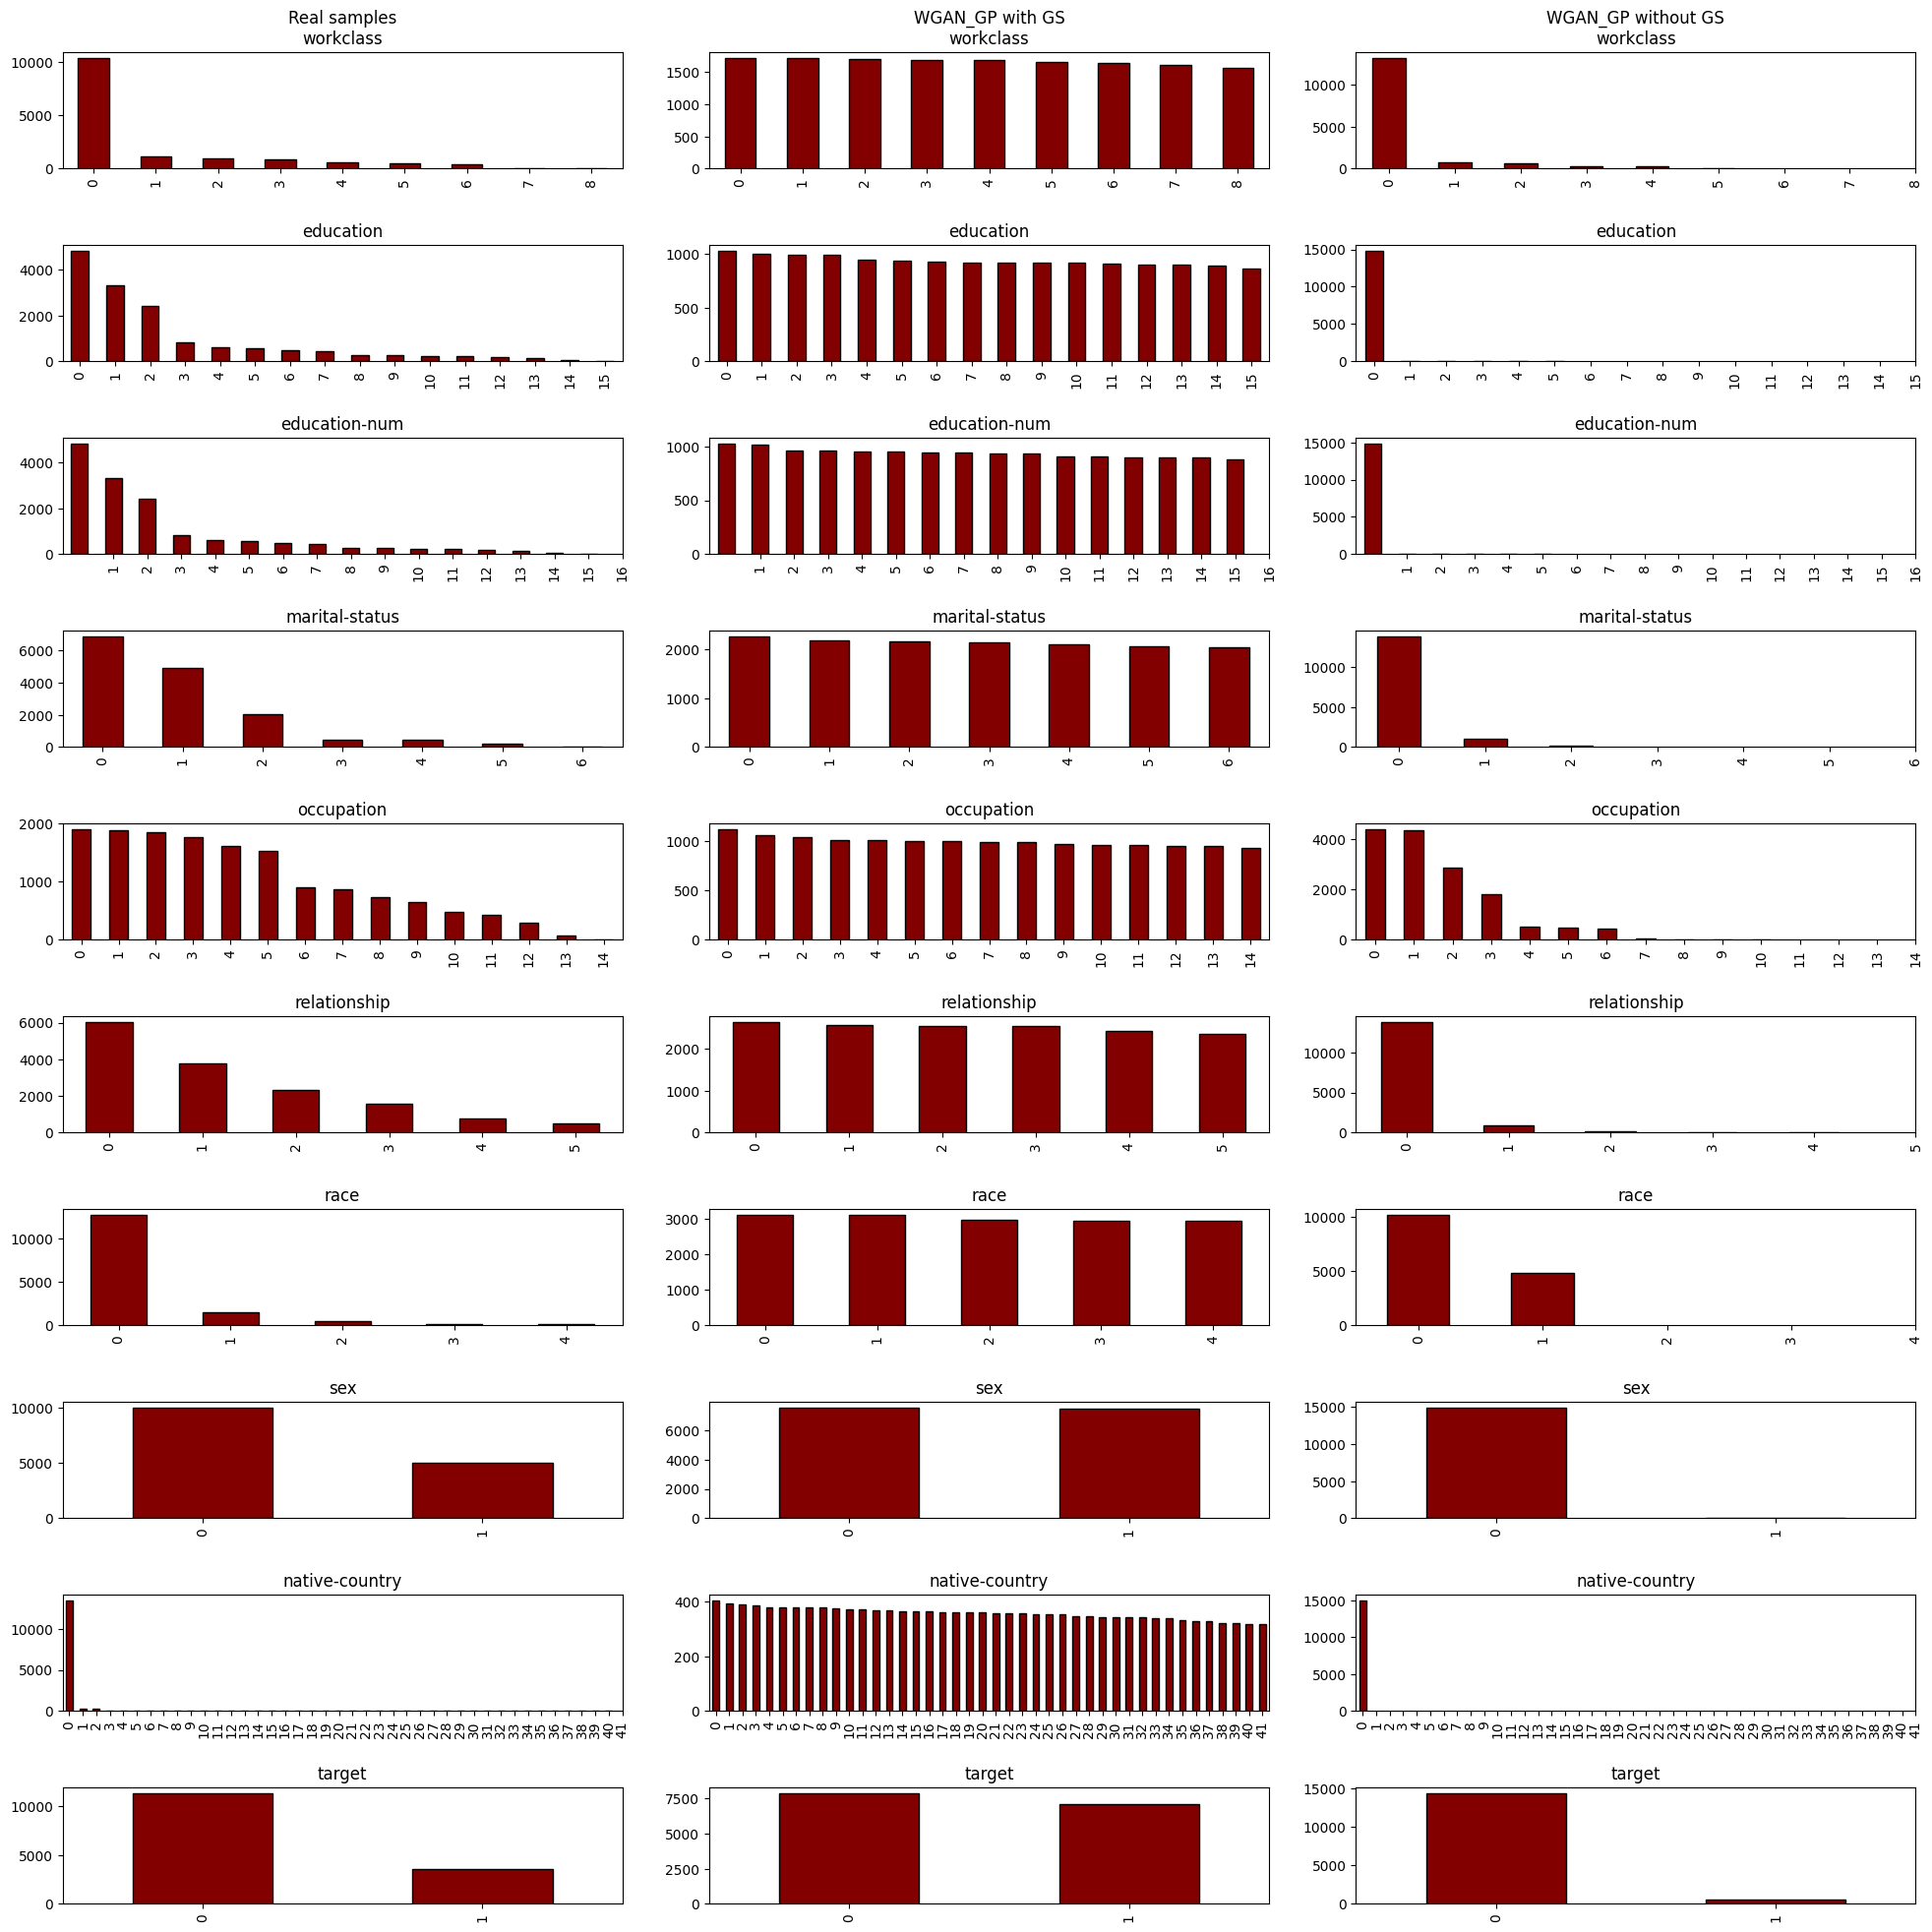

In [9]:
import matplotlib.pyplot as plt
from ydata_synthetic.utils.misc.colormaps import ydata_colormap

ydata_colors = ydata_colormap(1)

fig, axes = plt.subplots(nrows=len(cat_cols), ncols=3, figsize= (20,20))
for i, feat in enumerate(cat_cols):
    xticks=sorted(list(data[feat].unique()))
    for j, (name, samples) in enumerate({'Real samples': real_samples, 'WGAN_GP with GS': gs_samples, 'WGAN_GP without GS': no_gs_samples}.items()):
        samples[feat].value_counts().plot(kind='bar', ax=axes[i, j], title=(name +'\n' if i==0 else '') + feat, colormap=ydata_colors, edgecolor='black',
        xticks=xticks)
fig.tight_layout(pad=2.0)
plt.show()

Did you notice the difference of the Gumbel-Softmax?
By default this feature is implemented in all the regular generators.

Feel free to adapt this notebook to play with different parameters, datasets or even other GANs of the repository.

Also, enjoy the improved categorical generation!